Importando las librerías necesarias

In [1]:
import numpy as np
from scipy import misc
from PIL import Image
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn
import pandas as pd
import pickle
from keras import layers
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import layer_utils, np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras import losses
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

Preparando el conjunto de datos
Como antes, usaremos el conjunto de datos CIFAR-100, que, como ya dijimos, consta de 600 imágenes por cada clase de un total de 100 clases. Se divide en 500 imágenes para entrenamiento y 100 imágenes para validación por cada clase. Las 100 clases están agrupadas en 20 superclases. Cada imagen tiene una etiqueta "fina" (la clase, de entre las 100, a la que pertenece) y una etiqueta "gruesa" (correspondiente a su superclase).

In [2]:
from keras.datasets import cifar100

(x_train_original, y_train_original), (x_test_original, y_test_original) = cifar100.load_data(label_mode='fine')

Actualmente, hemos descargado los datasets de entrenamiento y validación. x_train_original y x_test_original son los conjuntos de datos con lás imágenes de entrenamiento y validación respectivamente, mientras que y_train_original y y_test_original son los datasets con las etiquetas.

Veíamos que la forma de y_train_original era la siguiente:

array([[19], [29], [ 0], ..., [ 3], [ 7], [73]])

Así que, inicialmente, había que convertirlo en su versión one-hot-encoding

In [3]:
y_train = np_utils.to_categorical(y_train_original, 100)
y_test = np_utils.to_categorical(y_test_original, 100)

El siguiente paso era ver los datos de entrenamiento (x_train_original)

In [4]:
x_train_original[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [195, 205, 193],
        [212, 224, 204],
        [182, 194, 167]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [170, 176, 150],
        [161, 168, 130],
        [146, 154, 113]],

       [[255, 255, 255],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [189, 199, 169],
        [166, 178, 130],
        [121, 133,  87]],

       ...,

       [[148, 185,  79],
        [142, 182,  57],
        [140, 179,  60],
        ...,
        [ 30,  17,   1],
        [ 65,  62,  15],
        [ 76,  77,  20]],

       [[122, 157,  66],
        [120, 155,  58],
        [126, 160,  71],
        ...,
        [ 22,  16,   3],
        [ 97, 112,  56],
        [141, 161,  87]],

       [[ 87, 122,  41],
        [ 88, 122,  39],
        [101, 134,  56],
        ...,
        [ 34,  36,  10],
        [105, 133,  59],
        [138, 173,  79]]

Representa la imagen en los 3 canales RGB de 256 píxeles. Vamos a verla.

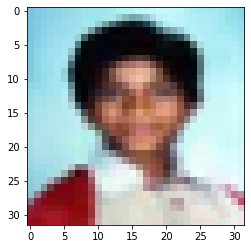

In [5]:
imgplot = plt.imshow(x_train_original[3])
plt.show()

Lo que haremos a continuación, será normalizar las imágenes dividiéndo cada elemento por el numero de píxeles, es decir, 255. Con lo que obteníamos el array con valores de entre 0 y 1.

In [6]:
x_train = x_train_original/255
x_test = x_test_original/255

Preparando el entorno
Especificabamos la situación de los canales de las imágenes y la fase del experimento.

In [8]:
K.set_image_data_format('channels_last')

In [9]:
K.set_learning_phase(True)  

Entrenando la red convolucional
En este paso, vamos a definir el modelo de red convolucional.

In [10]:
def create_simple_cnn():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
  
  model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='softmax'))
  
  return model

Como se puede ver en el código, la instrucción Conv2D introduce una capa convolucional y la instrucción MaxPooling, la capa de pooling (en esta red hemos realizado max-pooling, pero podíamos haber usado otras como average pooling). Para cada convolución unamos como función de activación ReLu. Otra instrucción nueva es Dropout, con la que hacemos la función de regularización Dropout.

Una vez definido el modelo, lo compilamos especificando la función de optimización, la de coste o pérdida y las métricas que usaremos. En este caso, como en el anterior, usaremos la función de optimización stochactic gradient descent, la función de pérdida categorical cross entropy y, para las métricas, accuracy y mse (media de los errores cuadráticos).

In [11]:
scnn_model = create_simple_cnn()
scnn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])

Una vez hecho esto, vamos a ver un resumen del modelo creado.

In [12]:
scnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 512)         1180160   
                                                        

Podemos ver que hemos doblado el número de parámetros. Si hubiésemos usado una red "tradicional" para lo que vamos a realizar, el número de parámetros hubiera crecido demasiado. Con el paso de la convolución, lo que va a hacer el modelo será extraer parámetros de la imagen.

Ahora sólo queda entrenar, para ello, haremos lo siguiente:

Le decimos a Keras que queremos usar para entrenar el dataset imágenes normalizadas de entrenamiento con el array de etiquetas one-hot-encoding. Usaremos batches o bloques de 32 (reduciendo la necesidad de memoria) y daremos 10 vueltas completas (o epochs). Usaremos los datos para validar x_test e y_test. El proceso de entrenamiento lo iremos viendo a continuación hasta terminar. El resultado del entrenamiento se guarda en la variable scnn, de la cual, extraeremos el histórico de los datos del entrenamiento.

Como se puede ver, las instrucciones tras el metodo que define el modelo son exactamente iguales.

In [13]:
scnn = scnn_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 602s 385ms/step - loss: 4.5997 - acc: 0.0125 - mse: 0.0099 - val_loss: 4.5776 - val_acc: 0.0140 - val_mse: 0.0099
Epoch 2/10
1563/1563 [==============================] - 591s 378ms/step - loss: 4.4304 - acc: 0.0307 - mse: 0.0099 - val_loss: 4.2341 - val_acc: 0.0553 - val_mse: 0.0098
Epoch 3/10
1563/1563 [==============================] - 629s 403ms/step - loss: 4.1981 - acc: 0.0596 - mse: 0.0098 - val_loss: 4.0160 - val_acc: 0.0949 - val_mse: 0.0097
Epoch 4/10
1563/1563 [==============================] - 630s 403ms/step - loss: 3.9877 - acc: 0.0916 - mse: 0.0097 - val_loss: 3.8273 - val_acc: 0.1143 - val_mse: 0.0095
Epoch 5/10
1563/1563 [==============================] - 621s 397ms/step - loss: 3.8095 - acc: 0.1217 - mse: 0.0095 - val_loss: 3.6485 - val_acc: 0.1556 - val_mse: 0.0094
Epoch 6/10
1563/1563 [==============================] - 625s 400ms/step - loss: 3.6462 - acc: 0.1505 - mse: 0.0094 - val_loss: 3.5194 - val_acc: 0.175

Al igual que antes, aunque hemos evaluado durante el entrenamiento, podríamos evaluarlo frente a otro dataset.

In [14]:
cnn_evaluation = scnn_model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)
cnn_evaluation

313/313 [==============================] - 12s 38ms/step - loss: 3.0579 - acc: 0.2640 - mse: 0.0086


[3.057915210723877, 0.2639999985694885, 0.008608411066234112]

Veamos las métricas obtenidas para el entrenamiento y validación gráficamente (para ello usamos la librería matplotlib)

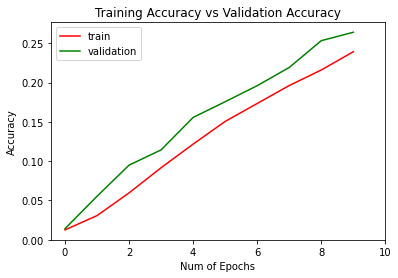

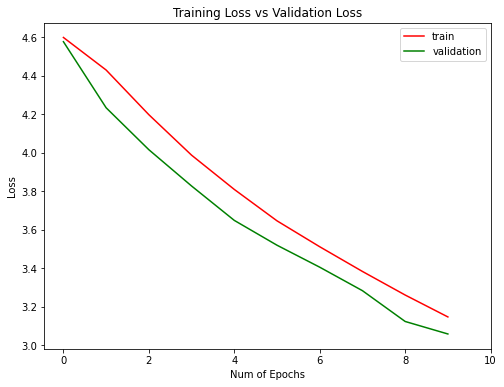

In [15]:
plt.figure(0)
plt.plot(scnn.history['acc'],'r')
plt.plot(scnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(scnn.history['loss'],'r')
plt.plot(scnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

La generalización es mejor que la red sencilla ya que , a diferencia del 4% de la red sencilla, éste tiene un 2% que, ni mucho menos, es un buen resultado.


Matriz de confusión
Una vez que hemos entrenado el modelo, vamos a ver otras métricas. Para ello, crearemos la matriz de confusión con SciKit Learn y, a partir de ella, veremos las métricas precission, recall y F1-score.

Vamos a hacer una predicción sobre el dataset de validación y, a partir de ésta, generamos la matriz de confusión y mostramos las métricas mencionadas anteriormente.

In [16]:
scnn_pred = scnn_model.predict(x_test, batch_size=32, verbose=1)
scnn_predicted = np.argmax(scnn_pred, axis=1)

313/313 [==============================] - 12s 38ms/step


Vamos a definir el mayor valor de la predicción. Lo normal es dar un valor mínimo o bias que defina un resultado como positivo, pero en este caso, lo vamos a hacer simple.

Con la librería Scikit Learn, generamos la matriz de confusión y la dibujamos (aunque el gráfico no es muy bueno debido al numero de etiquetas).

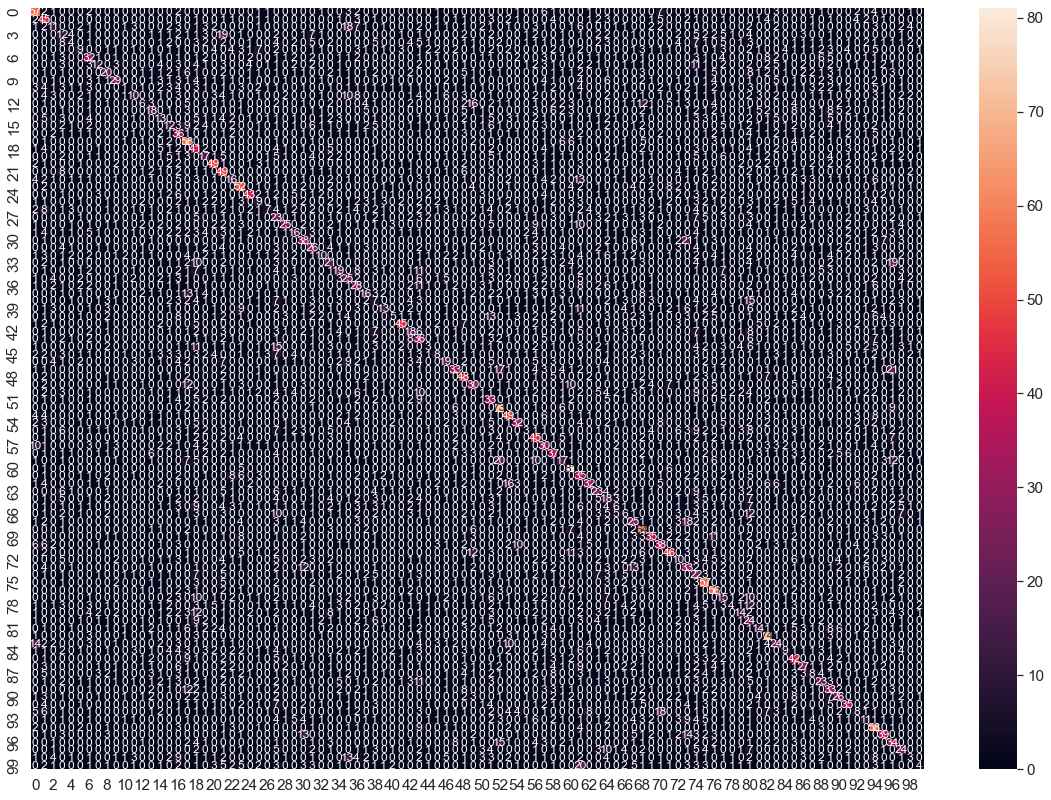

In [17]:
#Creamos la matriz de confusión
scnn_cm = confusion_matrix(np.argmax(y_test, axis=1), scnn_predicted)

# Visualiamos la matriz de confusión
scnn_df_cm = pd.DataFrame(scnn_cm, range(100), range(100))
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4) #for label size
sn.heatmap(scnn_df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

Y por último, mostramos las métricas

In [18]:
scnn_report = classification_report(np.argmax(y_test, axis=1), scnn_predicted)
print(scnn_report)

              precision    recall  f1-score   support

           0       0.42      0.57      0.48       100
           1       0.26      0.45      0.33       100
           2       0.23      0.11      0.15       100
           3       0.11      0.12      0.11       100
           4       0.15      0.04      0.06       100
           5       0.23      0.09      0.13       100
           6       0.30      0.32      0.31       100
           7       0.34      0.12      0.18       100
           8       0.32      0.20      0.25       100
           9       0.48      0.29      0.36       100
          10       0.07      0.01      0.02       100
          11       0.28      0.10      0.15       100
          12       0.21      0.06      0.09       100
          13       0.28      0.18      0.22       100
          14       0.17      0.13      0.15       100
          15       0.16      0.12      0.14       100
          16       0.20      0.36      0.25       100
          17       0.30    

Curva ROC (tasas de verdaderos positivos y falsos positivos)

C:\Users\INVITA~1\AppData\Local\Temp/ipykernel_2168/1876756933.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


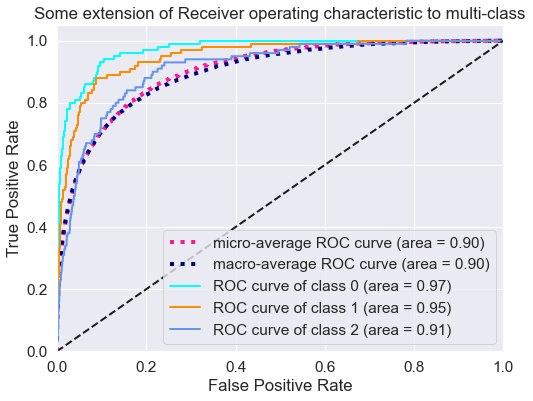

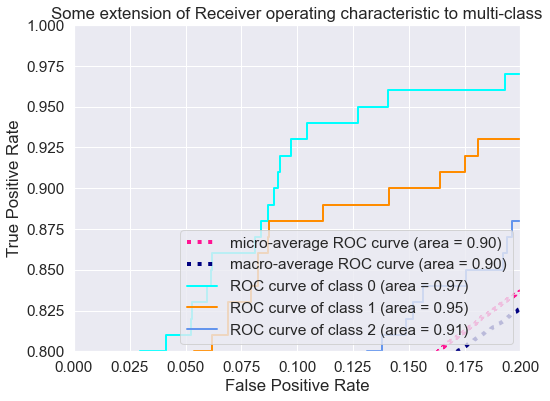

In [19]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes = 100

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], scnn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), scnn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Vamos a ver algunos resultados

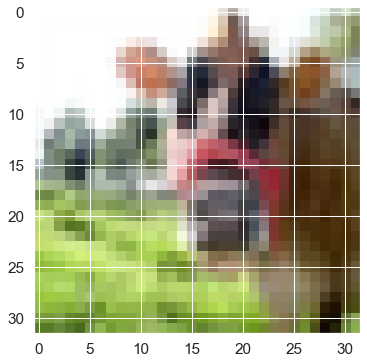

class for image 1: 49
predicted:         8


In [20]:
imgplot = plt.imshow(x_train_original[0])
plt.show()
print('class for image 1: ' + str(np.argmax(y_test[0])))
print('predicted:         ' + str(scnn_predicted[0]))

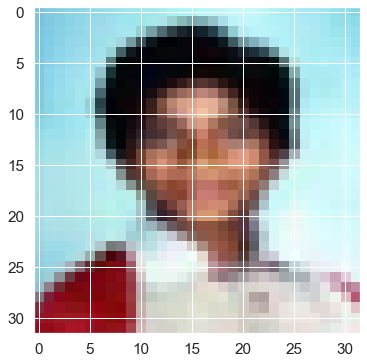

class for image 3: 51
predicted:         51


In [21]:
imgplot = plt.imshow(x_train_original[3])
plt.show()
print('class for image 3: ' + str(np.argmax(y_test[3])))
print('predicted:         ' + str(scnn_predicted[3]))

Salvaremos los datos del histórico de entrenamiento para compararlos con otros modelos.

In [22]:
#Histórico
with open('scnn_history.txt', 'wb') as file_pi:
  pickle.dump(scnn.history, file_pi)

A continuación, vamos a comparar los datos de precisión entre el modelo entrenado con una red convolucional de este trabajo con los datos del modelo anterior. Lo primero será cargar los datos del histórico del entrenamiento del modelo anterior.

In [23]:
with open('simplenn_history.txt', 'rb') as f:
  snn_history = pickle.load(f)

Ya lo tenemos en la variable snn_history. Ahora, comparemos las gráficas.

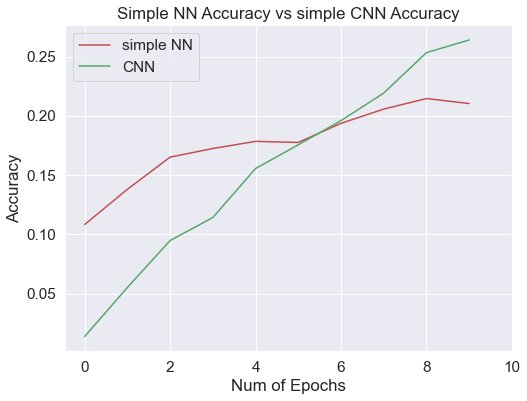

In [24]:
plt.figure(0)
plt.plot(snn_history['val_acc'],'r')
plt.plot(scnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Simple NN Accuracy vs simple CNN Accuracy")
plt.legend(['simple NN','CNN'])


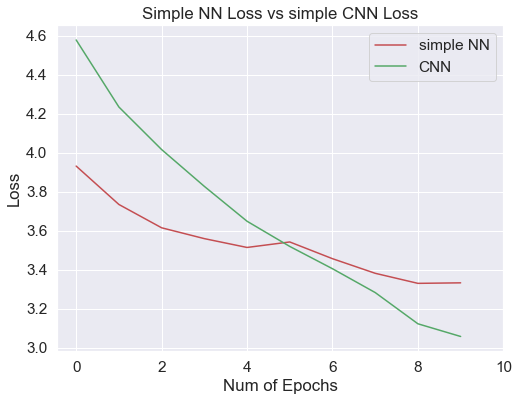

In [25]:
plt.figure(0)
plt.plot(snn_history['val_loss'],'r')
plt.plot(scnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Simple NN Loss vs simple CNN Loss")
plt.legend(['simple NN','CNN'])

In [26]:
plt.figure(0)
plt.plot(snn_history['val_mean_squared_error'],'r')
plt.plot(scnn.history['val_mean_squared_error'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Simple NN MSE vs simple CNN MSE")
plt.legend(['simple NN','CNN'])


KeyError: 'val_mean_squared_error'

<Figure size 576x432 with 0 Axes>

Conclusión sobre el segundo Trabajo Realizado
A diferencia del modelo anterior, las líneas de las gráficas no toman horizontalidad, por lo que se presupone que merece la pena seguir aumentando el número de epochs para mejorar el entrenamiento. La red convolutiva ha permitido mejorar la precisión general y ha generalizado un poco mejor que la red neuronal simple.

Pero no nos dejemos engañar...
Como no es oro todo lo que reluce, hemos realizado el entrenamiento del modelo para 20 epochs más (a partir del ya entrenado). Si vemos los resultados del entrenamiento veremos lo siguiente:

¿Qué ha pasado?

Si bién la tasa de acierto ha aumentado con respecto a los primeros 10 epochs, ocurre que a medida que aumentaba el número de entrenamientos, Empezaba a generalizar menos. Se puede ver que la función de pérdida en los datos de validación alcanza un mínimo al llegar a un valor de 3 y, a partir de ahí, va aumentando. En gráfico de accuracy indica que el algoritmo no mejora de un valor de 30%. A partir de aquí, las opciones son usar métodos para regularizar o cambiar a un modelo mejor.